# Advanced Lane Finding
---

The goals / steps of this project are the following:

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Apply the distortion correction to the raw image.
3. Use color transforms, gradients, etc., to create a thresholded binary image.
4. Apply a perspective transform to rectify binary image ("birds-eye view").
5. Detect lane pixels and fit to find lane boundary.
6. Determine curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image.
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
---


In [1]:
#Import everything needed for the project

import numpy as np
import cv2
import pickle
import glob, os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import misc
from scipy.misc import imresize
import math


# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline


In [2]:
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Grayscale image
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    #print(gray)
    # Sobel x or y
    if orient == "x":
        sobelxy = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
        
    if orient == "y":
        sobelxy = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
        
    abssxy = np.absolute(sobelxy) # Absolute xy derivative to accentuate strong verticalish lines
    scale_factor = np.max(abssxy)/255 # Will use this to scale back to 8-bit scale
    abssxy = (abssxy/scale_factor).astype(np.uint8) #rescaling to 8-bit 

    # Threshold xy gradient
    retval, sxybinary = cv2.threshold(abssxy, thresh[0], thresh[1], cv2.THRESH_BINARY)

    return sxybinary

def mag_thresh(image, sobel_kernel=9, mag_thresh=(30, 100)):
    # Grayscale image
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    #print(gradmag)

    retval, mag_binary = cv2.threshold(gradmag, mag_thresh[0], mag_thresh[1], cv2.THRESH_BINARY)
    
    return mag_binary

def dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.4)):
    
    # Calculate gradient direction
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # To avoid error messages due to diving by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        absgraddir = np.absolute(np.arctan(sobely/sobelx))
        retval, s_binary = cv2.threshold(s.astype('uint8'), thresh[0], thresh[1], cv2.THRESH_BINARY)
        
    return dir_binary

def rgb2hls(img, thresh=(0, 255)):    
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    #print(s)
    
    # Threshold color channel
    retval, s_binary = cv2.threshold(s.astype('uint8'), thresh[0], thresh[1], cv2.THRESH_BINARY)
    
    #print(s_binary)
    
    return s_binary




# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

In [3]:
def show_images(images,row,col, title):
        
    #Split the figure in x rows and y columns to put images
    figure, axes = plt.subplots(row,col, figsize=(24, 9))

    # hspace vertical space reserve for white space between subplots
    # wspace horizontal space reserve for white space between subplots
    figure.subplots_adjust(hspace=0.1)
    
    for i, ax in enumerate(axes.flat):
        image_shape = np.shape(images[i])
        ax.imshow(images[i].reshape(image_shape), cmap='gray')

        #ax.set_xticks([])
        #ax.set_yticks([])
        index = i +1
        msg = str("Test %g"%index + "_%s"%title)
        ax.set_title(msg)
        
    plt.subplots_adjust(left=0., right=0.4, top=0.9, bottom=0.)

    plt.show()

In [4]:
def pipeline_gradx_hls(img):
    img = np.copy(img)

    #HLS
    s_binary= hls_select(img, thresh=(50, 255))
    
   
    # Gradient x
    sxbinary = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(200, 250))

    combined_binary = np.clip(cv2.bitwise_or(s_binary, sxbinary), 0, 1).astype('uint8')
    
    return combined_binary
    

In [5]:
# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "calibration/dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]


In [6]:
def undistortion(img, mtx, dist):
    undst = cv2.undistort(img, mtx, dist, None, mtx)
    
    return undst

In [7]:
#Function to obtain a warped image

def warp(img, src, dst,image_size):  
        
    #Get the perspective transform.
    M = cv2.getPerspectiveTransform(src, dst)
    Minv =  cv2.getPerspectiveTransform(dst, src)
    
    #Warp an image using the perspective transform (M)
    warped = cv2.warpPerspective(img, M, (image_size[1],image_size[0]),  flags=cv2.INTER_LINEAR)   
    

    return warped, M, Minv

In [8]:

def find_two_peaks_image(image, side='left'):
    ''' Finds the center of the detected lanes'''

    out = np.zeros(image.shape[1])
    histogram = np.sum(image, axis=0, out = out)
    #plt.plot(histogram)
    
    first_half = len(histogram)/2
    left = histogram[:first_half]
    #print(left)
    left_first_peak = np.argmax(left)
    left_value_peak = left[left_first_peak]
    
    right = histogram[first_half:]
    right_first_peak = np.argmax(right)
    right_value_peak = left[right_first_peak]
     
    
    dummy_left_array = left[left_first_peak:]

    counter = 0
    for index in dummy_left_array:
        if index != 0:
            counter = counter +1
            left_second_peak = left_first_peak+counter
            
        
        else:
            left_second_peak = left_first_peak+counter
            break
    
    left_center = left_first_peak + (left_second_peak - left_first_peak)/2
    
    
    
    dummy_right_array = right[right_first_peak:]

    counter = 0
    for index in dummy_right_array:
        if index != 0:
            counter = counter +1
            right_second_peak = right_first_peak+counter
        
        else:
            right_second_peak = right_first_peak+counter
            break
    
    
    right_center = (right_first_peak + (right_second_peak- right_first_peak)/2) + first_half 
    
    if side == 'left':
        center = left_center
        
    else:
        center = right_center
    
    return center

In [9]:
def find_peak(image):

    out = np.zeros(image.shape[1])
    histogram = np.sum(image, axis=0, out = out)

    first_peak = np.argmax(histogram)
    value_peak = histogram[first_peak]

    dummy_histogram_array = histogram[first_peak:]

    counter = 0
    
    for white_count in dummy_histogram_array:
        if white_count != 0:
            counter = counter +1

        else:
            break
            
    second_peak = first_peak+counter
    
    peak = first_peak + (second_peak - first_peak)/2
     
    return peak
    

In [10]:
def sliding_window(image, center, delta):
    '''Iterate over the detected line to obtain the x coordinates of the center of
    lines, it start at the center obtain before '''
    
    
    
    WIDTH = image.shape[1]
    WINDOW_WIDTH = 100

    HEIGTH = image.shape[0]

    
    sections = int(HEIGTH / delta)
    x_centers = [center]
    y_centers = []
    y_initials = []
    y_start = HEIGTH

    for index in range(1,sections+1):
        y_final = HEIGTH - index*delta
        y_initials.append(y_start)
        
        left_limit = center-50
        right_limit = center+ 50
        
        
        image_test = image[y_final:y_start,left_limit: right_limit]

        center = find_peak(image_test) + left_limit
        x_centers.append(center)

        y_start = y_final
        
    

    
    return x_centers

In [11]:
def filter_pixels(image, x_center, width=100):
    '''Obtain the coordinates of the pixels on the lane'''
    rectangles = []
    x_pixels = []
    y_pixels = []
    
    
    sections = image.shape[0]/len(x_center)
    
    for index_y in range(image.shape[0]-1,-1,-1):
        center = x_center[(len(x_center)-1)-math.floor(index_y/sections)]
        for index_x in range(image.shape[1]):
            
            if abs(index_x - center) < int(width/2):
                pixel = image[index_y][index_x]
                if pixel:
                    x_pixels.append(index_x)
                    y_pixels.append(index_y)
    

    return x_pixels, y_pixels
                    

In [12]:
def guided_search(image, warped, recent_xfitted):
    '''Obtain the coordinates of the pixels of a 
    line starting at the same center of the last detected line, 
    avoids to do the sliding window.'''
    
    OFFSET = 30
    y_pixels = []
    x_pixels = []
    all_xlast_fitted = []
    all_ylast_fitted = []
    y_list = []
    x0_list = []

    for index_y in range(image.shape[0]-1,-1,-1):

        x_last_fit = int(recent_xfitted[int(index_y/7.2)])

            
        if x_last_fit - OFFSET < 0:
            x0 = 0
        else:
            x0 = x_last_fit - OFFSET
        
        if x_last_fit + OFFSET >= image.shape[1]:
            x1 = image.shape[1]
        else:
            x1 = x_last_fit + OFFSET

        for x_index in range(x0,x1):
            if warped[index_y][x_index] == 1:                   
                x_pixels.append(x_index)
                y_pixels.append(index_y)

    
    return x_pixels, y_pixels
        
                    

In [13]:
# Define a class to receive the characteristics of each line detection
class Line():
    
    
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        #slope for detected line
        self.slope = None
        #position car
        self.position = 0 
        
    
    
    def push_line(self, yvals, allx, ally):       
        '''A new line was detected so all the attributes need to be updated'''
        self.detected = True
        self.allx = allx
        self.ally = ally
        #plt.plot(allx, ally)
        #plt.gca().invert_yaxis()
        y_eval = np.max(yvals)
        
        
        #side_fit = np.polyfit(self.ally, self.allx, 2)
        
        side_fit = Line.calculate_polyfit(ally, allx)        
        self.current_fit = side_fit    
        
        #xvals = side_fit[0]*yvals**2 + side_fit[1]*yvals + side_fit[2]
        xvals = Line.calculate_xvalues(yvals, side_fit)
        
        self.calculate_average_xvalues(np.array(xvals))
        
        #Curvature in pixels
        #side_curverad = ((1 + (2*side_fit[0]*y_eval + side_fit[1])**2)**1.5) \
                             #/np.absolute(2*side_fit[0])
        
        side_curverad = Line.calculate_curvature_pixels(side_fit, y_eval)
        self.radius_of_curvature = side_curverad
        
        self.slope = Line.calculate_slope(self.allx[0], self.allx[-1], self.ally[0],self.ally[-1])
        
        
    
    
        
    def get_curvature_meters(self, yvals, y_eval, ym_per_pix = 30/720, xm_per_pix = 3.7/700 ):
        ''' 
        ym_per_pix: meters per pixel in y dimension
        xm_per_pix: meteres per pixel in x dimension
        '''
        
        side_fit_cr = np.polyfit(self.ally*ym_per_pix, self.allx*xm_per_pix, 2)
        side_curverad = ((1 + (2*side_fit_cr[0]*y_eval + side_fit_cr[1])**2)**1.5) \
                            /np.absolute(2*side_fit_cr[0])
            
            
        return side_curverad
    
    
    def calculate_average_xvalues(self, xvals, n=5):
        self.recent_xfitted.append(xvals)
        
        if len(self.recent_xfitted) < n:
            n_last = self.recent_xfitted
        else:
            n_last = self.recent_xfitted[-n:]
            
        self.recent_xfitted = n_last
        self.bestx = np.mean(n_last, axis=0)

    @staticmethod
    def calculate_polyfit(ally, allx):
        coefficients = np.polyfit(ally, allx, 2)
        
        return coefficients
    
    
    @staticmethod
    def calculate_xvalues(yvals, side_fit):
        xvals = side_fit[0]*yvals**2 + side_fit[1]*yvals + side_fit[2]
        return xvals
    
    @staticmethod
    def calculate_curvature_pixels (side_fit, y_eval):
        curvature_pixels = ((1 + (2*side_fit[0]*y_eval + side_fit[1])**2)**1.5) \
                             /np.absolute(2*side_fit[0])
        
        return curvature_pixels
    
    @staticmethod
    def calculate_slope(x0,x1,y0,y1):
        slope = (y1-y0)/(x1-x0)
        return slope

In [14]:
def process_video(image, left_lane, right_lane,name_image):  
    '''Takes the image of the video and two instances of the Line class'''
    
    image_size = image.shape
    horizon = np.uint(2*image_size[0]/3)
    bottom = np.uint(image_size[0])
    center_lane = np.uint(image_size[1]/2)
    offset = 0.2

    x_left_bottom = center_lane - center_lane
    x_right_bottom = 2*center_lane
    x_right_upper = center_lane + offset*center_lane
    x_left_upper = center_lane - offset*center_lane
    
    


    source = np.float32([[x_left_bottom,bottom],[x_right_bottom,bottom],[x_right_upper,horizon],[x_left_upper,horizon]])

    destination = np.float32([[0,image_size[0]],[image_size[1],image_size[0]],
                  [image_size[1],0],[0,0]])
    
    
    yvals = np.linspace(0, 100, num=101)*7.2  # to cover same y-range as image
    y_eval = np.max(yvals)
    
    image_undis = undistortion(image, mtx, dist)
    image_size = image_undis.shape
    warped, M, Minv =  warp(image_undis,source,destination, image_size)
    warped = pipeline_gradx_hls(warped)
    
 
    HEIGHT = range(image.shape[0]-1,0, -100)

    #LEFT LANE
    if not left_lane.detected:
        
        center1= find_two_peaks_image(warped)
        
        x_center = sliding_window(warped, center1, 120)
        
        x_pixels,y_pixels = filter_pixels(warped,x_center)
        
        print('Blind search')

        new_line_detected_left = Line()
        
        if len(x_pixels) != 0 and len(y_pixels)!= 0:
            new_line_detected_left.detected = True
            new_line_detected_left.push_line(yvals, np.array(x_pixels), np.array(y_pixels))
 
    else:

        new_line_detected_left = Line()
        x_pixels, y_pixels = guided_search(image, warped, left_lane.recent_xfitted[-1])
        if len(x_pixels) != 0 and len(y_pixels)!= 0:
            new_line_detected_left.detected = True
            new_line_detected_left.push_line(yvals, np.array(x_pixels), np.array(y_pixels))

        

    #RIGTH LANE
    if not right_lane.detected:
        center2 = find_two_peaks_image(warped, 'right')

        x2_center = sliding_window(warped, center2, 120)

        x_pixels_r,y_pixels_r = filter_pixels(warped,x2_center)

        new_line_detected_right = Line()

        if len(x_pixels_r) != 0 and len(y_pixels_r)!= 0:
            new_line_detected_right.detected = True
            new_line_detected_right.push_line(yvals, np.array(x_pixels_r), np.array(y_pixels_r))
        
        
    else: 
        
        new_line_detected_right = Line()
        x_pixels_r, y_pixels_r =guided_search(image, warped, right_lane.recent_xfitted[-1])
        if len(x_pixels_r) != 0 and len(y_pixels_r)!= 0:
            new_line_detected_right.detected = True
            new_line_detected_right.push_line(yvals, np.array(x_pixels_r), np.array(y_pixels_r))
         

    
    if new_line_detected_left.detected and new_line_detected_right.detected:
        check_slope = 1 < abs(new_line_detected_left.slope)
        check_slope = 1 < abs(new_line_detected_right.slope) and check_slope
        check_curve = new_line_detected_left.radius_of_curvature > 1100
        check_curve = new_line_detected_right.radius_of_curvature > 1100 and check_curve
        
        check_distance = True
        for index in range(len(new_line_detected_left.recent_xfitted[-1])):
            distance =new_line_detected_left.recent_xfitted[-1][index]-new_line_detected_right.recent_xfitted[-1][index]
            
            if (abs(distance)) < 600:            
                check_distance = False
        

        if check_slope and check_curve and check_distance:

        
            left_lane.push_line(yvals, new_line_detected_left.allx,new_line_detected_left.ally)
            left_lane.detected = True
        
            right_lane.push_line(yvals,new_line_detected_right.allx, new_line_detected_right.ally) 
            right_lane.detected = True
            
            
            CENTER = image.shape[1]/2
            #print(CENTER)
            xm_per_pix = 3.7/700
        
            lanes_middle_distance = abs(right_lane.recent_xfitted[-1][0] + left_lane.recent_xfitted[-1][0])/2
            #print(lanes_middle_distance)
            position_car_pixels = abs(CENTER - lanes_middle_distance )
            #print(position_car_pixels)
            position_car_meters = position_car_pixels *xm_per_pix
            left_lane.position = position_car_meters
            
            #print(str(position_car_meters), 'm')
            
            
        else:
            #pass
            print('Bad Line: ','Slope',check_slope,'Curve:',check_curve, 'Distance', check_distance)
            print(image_name,'slope l: ', str(new_line_detected_left.slope), 'slope r:', str(new_line_detected_right.slope))
            print(image_name,'curvature l:', str(new_line_detected_left.radius_of_curvature), 'curvature r:', str(new_line_detected_right.radius_of_curvature ))

        
    else:
        left_lane.detected = False
        right_lane.detected = False

    #Drawing the lines back down onto the road
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))


    # Recast the x and y points into usable format for cv2.fillPoly()

    left_msg = ''
    right_msg = ''
    position_msg = ''
    
    font = cv2.FONT_HERSHEY_COMPLEX
    if left_lane.bestx is not None and right_lane.bestx is not None:
        pts_left = np.array([np.transpose(np.vstack([left_lane.bestx, yvals]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_lane.bestx, yvals])))])
        pts = np.hstack((pts_left, pts_right))
        
        
        left_msg = 'Left curvature: '+ str(np.round(left_lane.get_curvature_meters(yvals, y_eval)))+'m'
        right_msg = 'Right curvature: '+ str(np.round(left_lane.get_curvature_meters(yvals, y_eval)))+'m'
        position_msg = 'Car position:' + str(round(left_lane.position,3)) + 'm'
        
    # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))


    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 

    # Combine the result with the original image
    result = cv2.addWeighted(image_undis, 1, newwarp, 0.3, 0)

    cv2.putText(result, left_msg, (30, 60), font, 1, (0,0,0), 2)
    cv2.putText(result, right_msg, (800, 60), font, 1, (0,0,0), 2)
    cv2.putText(result, position_msg, (500, 550), font, 1, (0,0,0), 2)

    return result
           

Blind search
Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -27.4230769231 slope r: -4.11764705882
frames_test/frame611.jpg curvature l: 78836.7987626 curvature r: 1050.6182626


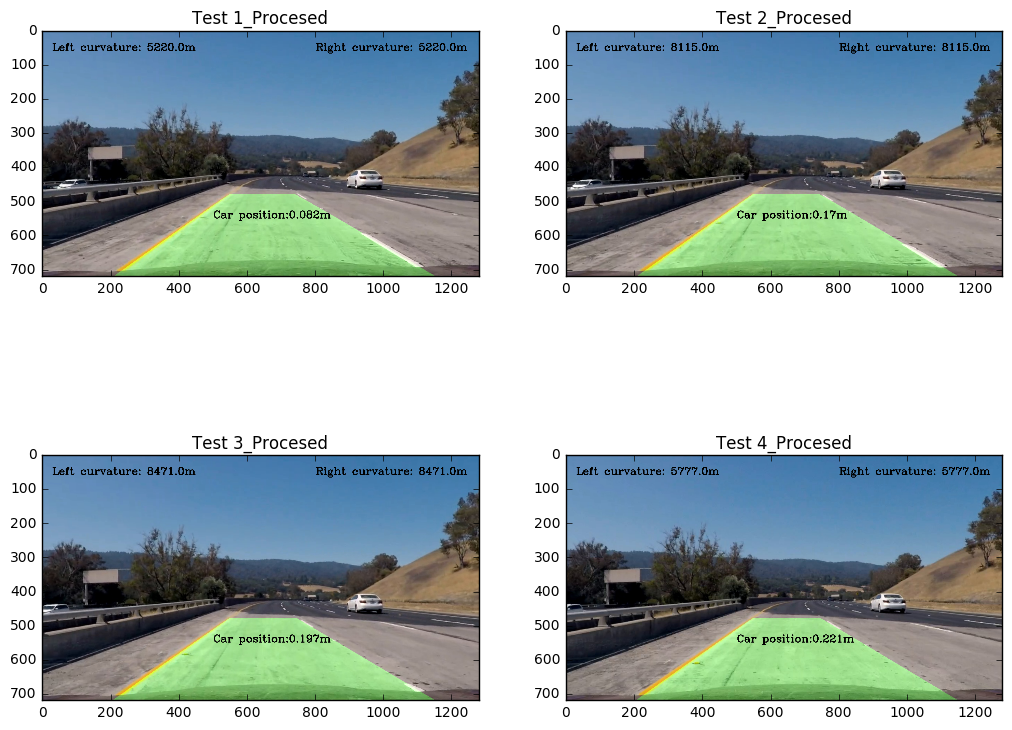

In [15]:
#Only for testing
images_proccesed =[]
images = glob.glob('frames_test/*.jpg')
images.sort()

left_lane = Line()
right_lane = Line()
for idx, image_name in enumerate(images):
    name = image_name.split('/')
    #print(name)
    img =  mpimg.imread(image_name)
    #plt.imshow(img)
    procesed= process_video(img, left_lane, right_lane,name )
    #print (filtered)
    images_proccesed.append(procesed)
    

n_row = 2
n_col = 2
show_images(images_proccesed,n_row,n_col,"Procesed")






In [16]:
#ensures that old instances are deleted
del(left_lane)
del(right_lane)

#creates new instances with default values
left_lane = Line()
right_lane = Line()

def wrapper(image):
    """wrapper to send 2 intances of the Line class to the function process_video()"""
    global left_lane
    global right_lane
    result = process_video(image, left_lane, right_lane, '')
    return result

In [17]:
#To process the video 
output = 'output_6.mp4'
#output = 'output_hard.mp4'
#file = VideoFileClip("hard.mp4");
file = VideoFileClip("project_video.mp4");

out = file.fl_image(wrapper) #NOTE: this function expects color images!!
%time out.write_videofile(output, audio=False);

Blind search
[MoviePy] >>>> Building video output_6.mp4
[MoviePy] Writing video output_6.mp4


 31%|███▏      | 395/1261 [02:35<05:34,  2.59it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -19.7222222222 slope r: 8.21621621622
frames_test/frame611.jpg curvature l: 12180.3402884 curvature r: 967.410791749


 31%|███▏      | 396/1261 [02:35<05:27,  2.64it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -20.2857142857 slope r: 6.475
frames_test/frame611.jpg curvature l: 10967.904426 curvature r: 1058.7492283


 49%|████▊     | 612/1261 [03:57<04:10,  2.60it/s]

Bad Line:  Slope True Curve: False Distance False
frames_test/frame611.jpg slope l:  -23.8 slope r: -1.57142857143
frames_test/frame611.jpg curvature l: 18619.5929947 curvature r: 102.733228949


 49%|████▊     | 613/1261 [03:57<03:59,  2.70it/s]

Bad Line:  Slope False Curve: True Distance False
frames_test/frame611.jpg slope l:  -24.6206896552 slope r: -0.444444444444
frames_test/frame611.jpg curvature l: 23281.7763689 curvature r: 40300106.7305


 49%|████▊     | 614/1261 [03:58<03:58,  2.71it/s]

Bad Line:  Slope False Curve: True Distance True
frames_test/frame611.jpg slope l:  -24.6206896552 slope r: -0.666666666667
frames_test/frame611.jpg curvature l: 11483.8411683 curvature r: 12707492.265


 49%|████▉     | 615/1261 [03:58<03:57,  2.73it/s]

Bad Line:  Slope False Curve: True Distance True
frames_test/frame611.jpg slope l:  -27.4615384615 slope r: -0.0645161290323
frames_test/frame611.jpg curvature l: 17485.8188529 curvature r: 67867203.013


 49%|████▉     | 616/1261 [03:59<03:52,  2.77it/s]

Bad Line:  Slope False Curve: True Distance False
frames_test/frame611.jpg slope l:  -24.6206896552 slope r: -0.2
frames_test/frame611.jpg curvature l: 8611.97145725 curvature r: 1374345.10573


 49%|████▉     | 617/1261 [03:59<03:52,  2.77it/s]

Bad Line:  Slope False Curve: True Distance False
frames_test/frame611.jpg slope l:  -24.6206896552 slope r: 0.368421052632
frames_test/frame611.jpg curvature l: 5492.27509825 curvature r: 2731807.7343


 49%|████▉     | 618/1261 [03:59<03:49,  2.80it/s]

Bad Line:  Slope False Curve: True Distance False
frames_test/frame611.jpg slope l:  -24.6206896552 slope r: -0.8
frames_test/frame611.jpg curvature l: 5721.64137647 curvature r: 77493.6917948


 49%|████▉     | 619/1261 [04:00<03:47,  2.82it/s]

Bad Line:  Slope True Curve: False Distance False
frames_test/frame611.jpg slope l:  -23.0322580645 slope r: 11.1
frames_test/frame611.jpg curvature l: 5773.27542789 curvature r: 574.843857769


 49%|████▉     | 622/1261 [04:01<03:54,  2.73it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -10.2 slope r: -inf
frames_test/frame611.jpg curvature l: 11849.9673028 curvature r: 743.746657112


 50%|████▉     | 627/1261 [04:03<03:56,  2.68it/s]

Bad Line:  Slope True Curve: False Distance False
frames_test/frame611.jpg slope l:  -6.86538461538 slope r: -4.72222222222
frames_test/frame611.jpg curvature l: 2952.78156779 curvature r: 392.417404013


 50%|████▉     | 629/1261 [04:03<03:53,  2.71it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -5.20437956204 slope r: -22.1538461538
frames_test/frame611.jpg curvature l: 3235.02063972 curvature r: 1066.78219798


 65%|██████▍   | 816/1261 [05:17<03:16,  2.26it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -10.2608695652 slope r: -35.3
frames_test/frame611.jpg curvature l: 5233.25581828 curvature r: 905.567537518


 65%|██████▍   | 817/1261 [05:17<03:10,  2.33it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -12.8035714286 slope r: 100.666666667
frames_test/frame611.jpg curvature l: 5785.82694161 curvature r: 666.075265537


 65%|██████▍   | 818/1261 [05:18<03:32,  2.09it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -10.2608695652 slope r: 25.4
frames_test/frame611.jpg curvature l: 5836.45888892 curvature r: 522.835837876


 65%|██████▍   | 819/1261 [05:18<03:26,  2.15it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -10.2608695652 slope r: 210.0
frames_test/frame611.jpg curvature l: 5194.31013509 curvature r: 415.103487943


 65%|██████▌   | 820/1261 [05:18<03:22,  2.18it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -9.97183098592 slope r: 5.10144927536
frames_test/frame611.jpg curvature l: 5147.44240576 curvature r: 577.400523968


 65%|██████▌   | 821/1261 [05:19<03:14,  2.26it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -11.5967741935 slope r: 8.75
frames_test/frame611.jpg curvature l: 4544.08188379 curvature r: 692.011083593


 66%|██████▌   | 826/1261 [05:21<02:44,  2.64it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -12.1525423729 slope r: 6.24637681159
frames_test/frame611.jpg curvature l: 3945.78294407 curvature r: 901.984063632


 66%|██████▌   | 827/1261 [05:21<02:58,  2.43it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -11.0461538462 slope r: 4.41860465116
frames_test/frame611.jpg curvature l: 4271.40467202 curvature r: 768.94349776


 66%|██████▌   | 828/1261 [05:22<02:50,  2.54it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -11.380952381 slope r: 4.33766233766
frames_test/frame611.jpg curvature l: 4387.75738286 curvature r: 683.506462996


 66%|██████▌   | 829/1261 [05:22<02:45,  2.61it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -10.8787878788 slope r: 3.39285714286
frames_test/frame611.jpg curvature l: 4408.48649603 curvature r: 629.817887106


 66%|██████▌   | 830/1261 [05:23<03:03,  2.35it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -10.8787878788 slope r: 2.81176470588
frames_test/frame611.jpg curvature l: 4768.19256252 curvature r: 582.215977627


 66%|██████▌   | 831/1261 [05:23<03:04,  2.33it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -11.380952381 slope r: 11.2931034483
frames_test/frame611.jpg curvature l: 4268.82322874 curvature r: 964.15234535


 66%|██████▌   | 832/1261 [05:23<03:19,  2.15it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -11.7540983607 slope r: 11.3620689655
frames_test/frame611.jpg curvature l: 3877.859065 curvature r: 1012.61232473


 66%|██████▋   | 836/1261 [05:25<03:18,  2.14it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -9.08974358974 slope r: 7.91176470588
frames_test/frame611.jpg curvature l: 4861.08495445 curvature r: 1066.14016831


 66%|██████▋   | 837/1261 [05:26<03:04,  2.30it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -9.98591549296 slope r: 6.41558441558
frames_test/frame611.jpg curvature l: 5254.27380328 curvature r: 968.598702161


 66%|██████▋   | 838/1261 [05:26<03:06,  2.26it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -9.32894736842 slope r: 5.85135135135
frames_test/frame611.jpg curvature l: 5265.89611658 curvature r: 838.146589181


 67%|██████▋   | 839/1261 [05:27<03:03,  2.29it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -9.71232876712 slope r: 4.34831460674
frames_test/frame611.jpg curvature l: 5163.23323609 curvature r: 781.137114899


 67%|██████▋   | 840/1261 [05:27<02:57,  2.37it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -9.08974358974 slope r: 3.33333333333
frames_test/frame611.jpg curvature l: 5902.7674143 curvature r: 760.667769142


 67%|██████▋   | 842/1261 [05:28<02:49,  2.47it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -9.84722222222 slope r: 21.0294117647
frames_test/frame611.jpg curvature l: 6947.28852317 curvature r: 1023.71823079


 67%|██████▋   | 843/1261 [05:28<02:46,  2.51it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -8.65853658537 slope r: 27.5
frames_test/frame611.jpg curvature l: 5208.05059907 curvature r: 995.421958966


 67%|██████▋   | 847/1261 [05:30<02:39,  2.59it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -9.35526315789 slope r: 10.5454545455
frames_test/frame611.jpg curvature l: 3207.42297334 curvature r: 1068.07817758


 67%|██████▋   | 848/1261 [05:30<02:38,  2.61it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -12.9272727273 slope r: 9.60714285714
frames_test/frame611.jpg curvature l: 3517.94936412 curvature r: 1006.72432367


 67%|██████▋   | 849/1261 [05:30<02:39,  2.58it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -12.2586206897 slope r: 7.546875
frames_test/frame611.jpg curvature l: 3613.94363744 curvature r: 879.301575775


 67%|██████▋   | 850/1261 [05:31<02:33,  2.68it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -11.85 slope r: 6.60606060606
frames_test/frame611.jpg curvature l: 3548.05954884 curvature r: 779.103455696


 67%|██████▋   | 851/1261 [05:31<02:30,  2.72it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -7.91111111111 slope r: 5.52173913043
frames_test/frame611.jpg curvature l: 3822.80247052 curvature r: 722.143332789


 68%|██████▊   | 852/1261 [05:31<02:28,  2.75it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -7.40625 slope r: 3.03669724771
frames_test/frame611.jpg curvature l: 3910.15772886 curvature r: 674.377427181


 68%|██████▊   | 853/1261 [05:32<02:26,  2.78it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -7.32989690722 slope r: 29.7916666667
frames_test/frame611.jpg curvature l: 4545.90527262 curvature r: 1016.75832316


 68%|██████▊   | 854/1261 [05:32<02:26,  2.77it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -7.73913043478 slope r: 47.6666666667
frames_test/frame611.jpg curvature l: 4287.11880492 curvature r: 996.167410041


 68%|██████▊   | 855/1261 [05:32<02:23,  2.83it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -7.0396039604 slope r: 238.0
frames_test/frame611.jpg curvature l: 4263.05928633 curvature r: 1040.95227541


 68%|██████▊   | 859/1261 [05:34<02:30,  2.67it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -8.01123595506 slope r: 9.04761904762
frames_test/frame611.jpg curvature l: 4322.35200121 curvature r: 1070.44015518


 68%|██████▊   | 860/1261 [05:34<02:29,  2.67it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -7.41666666667 slope r: 7.52173913043
frames_test/frame611.jpg curvature l: 4603.2091456 curvature r: 973.69139906


 68%|██████▊   | 861/1261 [05:35<02:29,  2.67it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -8.19540229885 slope r: 5.67073170732
frames_test/frame611.jpg curvature l: 4729.82473325 curvature r: 860.735606658


 68%|██████▊   | 862/1261 [05:35<02:26,  2.72it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -8.19540229885 slope r: 5.03614457831
frames_test/frame611.jpg curvature l: 4353.21367405 curvature r: 791.281923844


 68%|██████▊   | 863/1261 [05:35<02:24,  2.75it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -8.10227272727 slope r: 4.0
frames_test/frame611.jpg curvature l: 4289.32133231 curvature r: 749.832405945


 69%|██████▊   | 864/1261 [05:36<02:24,  2.75it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -7.83516483516 slope r: 3.9375
frames_test/frame611.jpg curvature l: 3965.4772918 curvature r: 696.67129625


 69%|██████▊   | 865/1261 [05:36<02:22,  2.77it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -8.9125 slope r: 39.5
frames_test/frame611.jpg curvature l: 4203.69606266 curvature r: 1050.47607984


 69%|██████▊   | 866/1261 [05:37<02:22,  2.77it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -7.58510638298 slope r: 59.5833333333
frames_test/frame611.jpg curvature l: 3628.06505911 curvature r: 1027.44102496


 69%|██████▉   | 870/1261 [05:38<02:21,  2.76it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -8.4880952381 slope r: 15.6666666667
frames_test/frame611.jpg curvature l: 3289.58256196 curvature r: 1068.6449881


 69%|██████▉   | 871/1261 [05:38<02:20,  2.77it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -8.18390804598 slope r: 8.79365079365
frames_test/frame611.jpg curvature l: 3347.74980137 curvature r: 992.972835413


 69%|██████▉   | 872/1261 [05:39<02:19,  2.79it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -8.10227272727 slope r: 9.84615384615
frames_test/frame611.jpg curvature l: 3575.04496155 curvature r: 898.226291258


 69%|██████▉   | 873/1261 [05:39<02:21,  2.75it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -8.38823529412 slope r: 7.203125
frames_test/frame611.jpg curvature l: 4011.59810731 curvature r: 797.529591444


 69%|██████▉   | 874/1261 [05:39<02:19,  2.77it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -8.29069767442 slope r: 5.81690140845
frames_test/frame611.jpg curvature l: 4323.73694097 curvature r: 722.379926754


 69%|██████▉   | 875/1261 [05:40<02:20,  2.74it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -7.91111111111 slope r: 4.05617977528
frames_test/frame611.jpg curvature l: 4054.05876909 curvature r: 674.63707998


 69%|██████▉   | 876/1261 [05:40<02:21,  2.72it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -7.92222222222 slope r: 3.39325842697
frames_test/frame611.jpg curvature l: 3642.2835987 curvature r: 647.98518385


 70%|██████▉   | 877/1261 [05:41<02:19,  2.76it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -8.20689655172 slope r: -47.8
frames_test/frame611.jpg curvature l: 3539.88357501 curvature r: 876.222537658


 70%|██████▉   | 878/1261 [05:41<02:20,  2.72it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -8.38823529412 slope r: 78.8888888889
frames_test/frame611.jpg curvature l: 3531.18269784 curvature r: 949.467758092


 70%|███████   | 883/1261 [05:43<02:22,  2.66it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -8.01123595506 slope r: 15.2432432432
frames_test/frame611.jpg curvature l: 3311.28145643 curvature r: 1036.34007016


 70%|███████   | 884/1261 [05:43<02:21,  2.66it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -8.3023255814 slope r: 10.5
frames_test/frame611.jpg curvature l: 3343.16190872 curvature r: 900.216823538


 70%|███████   | 885/1261 [05:44<02:24,  2.60it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -8.20689655172 slope r: 6.90769230769
frames_test/frame611.jpg curvature l: 3429.34940041 curvature r: 803.113427316


 70%|███████   | 886/1261 [05:44<02:21,  2.65it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -9.2987012987 slope r: 5.50704225352
frames_test/frame611.jpg curvature l: 3540.58580095 curvature r: 784.688515559


 70%|███████   | 887/1261 [05:44<02:22,  2.63it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -8.29069767442 slope r: 3.76923076923
frames_test/frame611.jpg curvature l: 3491.71114665 curvature r: 728.764383244


 70%|███████   | 888/1261 [05:45<02:20,  2.66it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -7.82417582418 slope r: 2.88
frames_test/frame611.jpg curvature l: 3515.37563267 curvature r: 671.932462075


 70%|███████   | 889/1261 [05:45<02:16,  2.72it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -8.19540229885 slope r: 2.4387755102
frames_test/frame611.jpg curvature l: 3435.81180704 curvature r: 688.077044133


 71%|███████   | 890/1261 [05:45<02:20,  2.65it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -7.73913043478 slope r: 668.0
frames_test/frame611.jpg curvature l: 3489.08852754 curvature r: 947.085419368


 71%|███████   | 894/1261 [05:47<02:13,  2.75it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -8.9125 slope r: 13.2954545455
frames_test/frame611.jpg curvature l: 8712.19005872 curvature r: 1050.71784


 71%|███████   | 895/1261 [05:47<02:14,  2.73it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -8.8024691358 slope r: 11.8
frames_test/frame611.jpg curvature l: 9196.7110259 curvature r: 941.660213556


 71%|███████   | 896/1261 [05:48<02:14,  2.72it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -9.52 slope r: 27.0555555556
frames_test/frame611.jpg curvature l: 10045.9467795 curvature r: 846.974407022


 71%|███████   | 897/1261 [05:48<02:14,  2.70it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -9.52 slope r: 22.1
frames_test/frame611.jpg curvature l: 9017.44461435 curvature r: 762.081637018


 71%|███████   | 898/1261 [05:48<02:15,  2.67it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -9.52 slope r: 16.375
frames_test/frame611.jpg curvature l: 9325.18068539 curvature r: 685.719304664


 71%|███████▏  | 899/1261 [05:49<02:12,  2.72it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -9.63513513514 slope r: 14.25
frames_test/frame611.jpg curvature l: 7135.39369574 curvature r: 629.333483693


 71%|███████▏  | 900/1261 [05:49<02:08,  2.81it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -9.50666666667 slope r: 7.0487804878
frames_test/frame611.jpg curvature l: 7083.44204529 curvature r: 611.623157579


 71%|███████▏  | 901/1261 [05:49<02:07,  2.83it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -11.3015873016 slope r: -44.875
frames_test/frame611.jpg curvature l: 7068.233305 curvature r: 1030.49433664


 72%|███████▏  | 907/1261 [05:52<02:12,  2.68it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -10.6119402985 slope r: 20.8076923077
frames_test/frame611.jpg curvature l: 11255.4115545 curvature r: 1022.13561881


 72%|███████▏  | 908/1261 [05:52<02:12,  2.67it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -11.4838709677 slope r: 10.5
frames_test/frame611.jpg curvature l: 10739.3469916 curvature r: 890.91124939


 72%|███████▏  | 909/1261 [05:52<02:09,  2.71it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -11.4838709677 slope r: 5.97222222222
frames_test/frame611.jpg curvature l: 10667.4608609 curvature r: 790.679611742


 72%|███████▏  | 910/1261 [05:53<02:09,  2.70it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -11.4838709677 slope r: 5.90625
frames_test/frame611.jpg curvature l: 12289.2673921 curvature r: 766.113974579


 72%|███████▏  | 911/1261 [05:53<02:06,  2.78it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -11.3015873016 slope r: 4.27272727273
frames_test/frame611.jpg curvature l: 13277.7431908 curvature r: 730.430009041


 72%|███████▏  | 912/1261 [05:53<02:07,  2.74it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -10.9384615385 slope r: 28.4
frames_test/frame611.jpg curvature l: 17872.1555617 curvature r: 1039.47756714


 72%|███████▏  | 913/1261 [05:54<02:08,  2.71it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -16.3409090909 slope r: 71.3
frames_test/frame611.jpg curvature l: 16056.8059904 curvature r: 1015.54097463


 73%|███████▎  | 919/1261 [05:56<02:03,  2.76it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -16.3409090909 slope r: -263.5
frames_test/frame611.jpg curvature l: 5755.51096592 curvature r: 1048.71820402


 73%|███████▎  | 920/1261 [05:56<02:04,  2.74it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -16.7209302326 slope r: 33.5714285714
frames_test/frame611.jpg curvature l: 6998.46669532 curvature r: 905.967159222


 73%|███████▎  | 921/1261 [05:57<02:01,  2.79it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -16.7209302326 slope r: 15.4814814815
frames_test/frame611.jpg curvature l: 7237.76908339 curvature r: 767.66710412


 73%|███████▎  | 922/1261 [05:57<02:02,  2.76it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -15.6304347826 slope r: 21.7058823529
frames_test/frame611.jpg curvature l: 8134.12698208 curvature r: 671.520938613


 73%|███████▎  | 923/1261 [05:57<02:02,  2.77it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -15.6304347826 slope r: 7.75609756098
frames_test/frame611.jpg curvature l: 10356.1409583 curvature r: 606.347673881


 75%|███████▌  | 947/1261 [06:06<01:49,  2.85it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -10.803030303 slope r: -15.9444444444
frames_test/frame611.jpg curvature l: 15670.217286 curvature r: 1082.26880267


 83%|████████▎ | 1045/1261 [06:44<01:18,  2.77it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -9.25974025974 slope r: -118.25
frames_test/frame611.jpg curvature l: 1627.94319065 curvature r: 1049.60835587


 83%|████████▎ | 1046/1261 [06:44<01:17,  2.78it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -9.14102564103 slope r: -18.7142857143
frames_test/frame611.jpg curvature l: 1992.85509882 curvature r: 997.908930555


 84%|████████▎ | 1053/1261 [06:46<01:16,  2.74it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -10.9538461538 slope r: -27.2857142857
frames_test/frame611.jpg curvature l: 2354.53859658 curvature r: 751.295617283


 84%|████████▎ | 1054/1261 [06:47<01:14,  2.78it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -7.83516483516 slope r: -34.2222222222
frames_test/frame611.jpg curvature l: 2493.25305543 curvature r: 584.047090283


 84%|████████▎ | 1055/1261 [06:47<01:12,  2.85it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -7.66666666667 slope r: -6.19230769231
frames_test/frame611.jpg curvature l: 2917.76734431 curvature r: 630.716263619


 98%|█████████▊| 1235/1261 [07:55<00:08,  3.04it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -9.875 slope r: -33.7
frames_test/frame611.jpg curvature l: 5450.69330439 curvature r: 907.58418563


 98%|█████████▊| 1236/1261 [07:56<00:08,  3.07it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -9.7397260274 slope r: -22.0
frames_test/frame611.jpg curvature l: 4973.07768653 curvature r: 687.088520708


 98%|█████████▊| 1237/1261 [07:56<00:08,  2.99it/s]

Bad Line:  Slope True Curve: False Distance True
frames_test/frame611.jpg slope l:  -9.7397260274 slope r: -29.75
frames_test/frame611.jpg curvature l: 4963.04015194 curvature r: 803.769789334


100%|█████████▉| 1260/1261 [08:04<00:00,  2.84it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_6.mp4 

CPU times: user 27min 30s, sys: 17.4 s, total: 27min 47s
Wall time: 8min 6s


In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))